# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl

In [3]:

class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/12")
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/11"))
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/10"))

paths = {}
keys = train_paths.keys()
for key in list(keys)[0:7]:
    paths.update({key: train_paths[key]})
train_paths = paths

print(train_paths)
print("----------------------------------------------------------------------------------------")
#test_paths = test_paths.popitem()
#test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)

    

{'20140115': {'x': 'dataset/Kyoto2016/2014/01/20140115_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140115_y.csv'}, '20140107': {'y': 'dataset/Kyoto2016/2014/01/20140107_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140107_x.csv'}, '20140109': {'x': 'dataset/Kyoto2016/2014/01/20140109_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140109_y.csv'}, '20140104': {'y': 'dataset/Kyoto2016/2014/01/20140104_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140104_x.csv'}, '20140119': {'x': 'dataset/Kyoto2016/2014/01/20140119_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140119_y.csv'}, '20140120': {'x': 'dataset/Kyoto2016/2014/01/20140120_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140120_y.csv'}, '20140123': {'x': 'dataset/Kyoto2016/2014/01/20140123_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140123_y.csv'}}
----------------------------------------------------------------------------------------
{'20151224': {'y': 'dataset/Kyoto2016/2015/12/20151224_y.csv', 'x': 'dataset/Kyoto2016/2015/12/20151224_x.csv'}, '20151204': {

In [4]:
import tensorflow as tf
from sklearn import model_selection as ms
from sklearn import metrics as me

In [5]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 42
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [6]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'quality_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                            train_batch()

                            count = 10
                            while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                                print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                             .format(epochs,h,f)))
                                train_batch()
                                count -=1

                            #summary_writer_train.add_summary(summary_str, epoch)
                            #if(train_loss > 1e9):

                            #print("{:.6f}".format(train_loss), end = ", " )

                        #print("")
                        valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                             net.y_: y_valid, 
                                                                             net.keep_prob:1, net.lr:lr})
                    end_time = time.perf_counter()
                    for key, x_test, y_test in preprocess.get_data(test_paths):

                        accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                       net.pred, 
                                                                       net.actual, net.y], 
                                                                      feed_dict={net.x: x_test, 
                                                                                 net.y_: y_test, 
                                                                                 net.keep_prob:1, net.lr:lr})
                        
                        quality_score = me.matthews_corrcoef(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        accuracy = me.roc_auc_score(actual_value, pred_value)
                        
                        print("Key {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, quality_score: {}".format(key, train_loss, valid_accuracy, accuracy, quality_score))
                       

                        if accuracy > Train.best_acc_global:
                            Train.best_acc_global = accuracy

                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)


                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):
                                                  (curr_pred, 
                                                   Train.result(key, f, h,valid_accuracy, accuracy, quality_score, end_time - start_time))})



In [7]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        print("********************************** Training ******************************")
        Train.predictions = {}
        Train.results = []
    
        
        features_arr = [1, 4, 8, 16, 42]
        hidden_layers_arr = [1, 3]

        epochs = [1]
        lrs = [1e-5]
        print("***************************** Entering Loop **********************")
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - hidden layers:{} features count:{}".format(h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl'):
            past_scores = df_results#temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")

        past_scores.append(df_results, ignore_index=True).to_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")

In [8]:
#%%timeit
Hyperparameters.start_training()

********************************** Training ******************************
***************************** Entering Loop **********************
Current Layer Attributes - hidden layers:1 features count:1
Key 20151224 | Training Loss: 0.020481 | Train Accuracy: 0.751854 | Test Accuracy: 0.495731, quality_score: -0.002561397883699275
Key 20151204 | Training Loss: 0.020481 | Train Accuracy: 0.751854 | Test Accuracy: 0.491857, quality_score: -0.004181009557801292
Key 20151216 | Training Loss: 0.020481 | Train Accuracy: 0.751854 | Test Accuracy: 0.457382, quality_score: -0.02759923482715811
Key 20151222 | Training Loss: 0.020481 | Train Accuracy: 0.751854 | Test Accuracy: 0.434051, quality_score: -0.03327870705543093
Key 20151214 | Training Loss: 0.020481 | Train Accuracy: 0.751854 | Test Accuracy: 0.467155, quality_score: -0.017923957347894873
Key 20151202 | Training Loss: 0.020481 | Train Accuracy: 0.751854 | Test Accuracy: 0.505657, quality_score: 0.00535877127260692
Key 20151227 | Trainin

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Key 20151224 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151204 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151216 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151222 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151214 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151202 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151227 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151203 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151223 | Training Loss: nan | Train Accuracy: 0.003690 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151205 | Training Loss: nan | T

Key 20151203 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151223 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151205 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151229 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151208 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151219 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151206 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151225 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151210 | Training Loss: nan | Train Accuracy: 0.003517 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151217 | Training Loss: nan | T

Key 20151209 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151228 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151226 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151218 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151231 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151212 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151211 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151221 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_score: 0.0
Key 20151201 | Training Loss: 0.012645 | Train Accuracy: 0.995758 | Test Accuracy: 0.500000, quality_sco

Key 20151228 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.499708, quality_score: -0.0005003936132641652
Key 20151226 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.501686, quality_score: 0.008263779805286023
Key 20151218 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.501341, quality_score: 0.0031312477042054762
Key 20151231 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.501422, quality_score: 0.006236180805208447
Key 20151212 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.500329, quality_score: 0.0007948118748140582
Key 20151211 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.502047, quality_score: 0.0033107859678981693
Key 20151221 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.504547, quality_score: 0.008452949056123885
Key 20151201 | Training Loss: 0.013566 | Train Accuracy: 0.979482 | Test Accuracy: 0.502770,

Key 20151226 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.499950, quality_score: -0.00044481916471713587
Key 20151218 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.498986, quality_score: -0.0044055773998393265
Key 20151231 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.500119, quality_score: 0.0009782215419102008
Key 20151212 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.500219, quality_score: 0.0009763810879239397
Key 20151211 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.500444, quality_score: 0.0013775030048540043
Key 20151221 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.499132, quality_score: -0.002957347923615317
Key 20151201 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.500378, quality_score: 0.0020297032967128603
Key 20151220 | Training Loss: 0.033081 | Train Accuracy: 0.993034 | Test Accuracy: 0.50

In [9]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [11]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")

In [12]:
past_scores.sort_values(by='quality_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,quality_score,time_taken
338,20151201,1,1,0.751854,0.571151,0.056364,27.131066
28,20151201,1,1,0.751854,0.571151,0.056364,27.131066
317,20151203,1,1,0.751854,0.538244,0.050518,27.131066
7,20151203,1,1,0.751854,0.538244,0.050518,27.131066
16,20151217,1,1,0.751854,0.541014,0.032795,27.131066
326,20151217,1,1,0.751854,0.541014,0.032795,27.131066
12,20151219,1,1,0.751854,0.516278,0.032117,27.131066
322,20151219,1,1,0.751854,0.516278,0.032117,27.131066
84,20151226,8,1,0.533915,0.526129,0.031308,23.117453
394,20151226,8,1,0.533915,0.526129,0.031308,23.117453


In [13]:
psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='quality_score', ascending=False)

,,key,train_score,test_score,quality_score,time_taken
no_of_features,hidden_layers,,,,,
1,1,20151201,0.751854,0.571151,0.056364,27.131066
8,1,20151226,0.533915,0.526129,0.031308,23.117453
4,3,20151203,0.987793,0.504681,0.028897,30.914805
8,3,20151219,0.979482,0.502937,0.021948,33.217086
16,3,20151231,0.754612,0.513905,0.017115,32.896400
42,3,20151209,0.993034,0.501394,0.005551,34.947012
1,3,20151219,0.995758,0.500000,0.000000,30.738411
4,1,20151225,0.003690,0.500000,0.000000,22.795788
16,1,20151230,0.003517,0.500000,0.000000,23.316731


In [14]:
#key_nof_hidden '20151201_16_1'
Train.predictions = pd.read_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")

In [15]:
df = Train.predictions['20151228_1_1'].dropna()

In [16]:
#Train.predictions['20151219_42_1'].loc[:,'Prediction']
df.loc[:,'Prediction'].values.astype(int)

array([0, 0, 0, ..., 1, 0, 0])

In [17]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.80636831084755589

In [18]:
df.groupby(by="Actual").Actual.count()

Actual
0.0      4159
1.0    363423
Name: Actual, dtype: int64

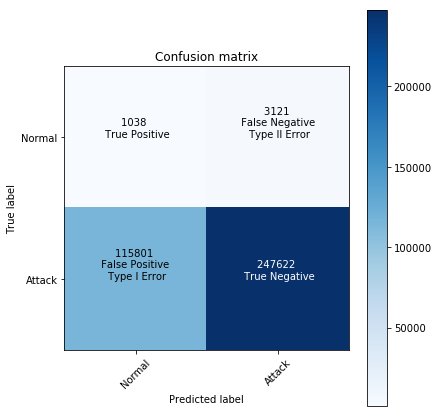

In [19]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [20]:
psg.mean().sort_values(by='quality_score', ascending=False)

train_score  test_score  quality_score  \
no_of_features hidden_layers                                           
8              3                 0.979482    0.502055       0.005885   
4              3                 0.987793    0.500665       0.003676   
1              3                 0.995758    0.500000       0.000000   
4              1                 0.003690    0.500000       0.000000   
16             1                 0.003517    0.500000       0.000000   
42             1                 0.003690    0.500000       0.000000   
               3                 0.993034    0.499790      -0.001025   
8              1                 0.533915    0.502968      -0.001159   
16             3                 0.754612    0.489737      -0.007540   
1              1                 0.751854    0.482744      -0.009051   

                              time_taken  
no_of_features hidden_layers              
8              3               33.217086  
4              3               30.914805  
1              3               30.738411  
4              1               22.795788  
16             1               23.316731  
42             1               28.740419  
               3               34.947012  
8              1               23.117453  
16             3               32.896400  
1              1               27.131066

In [21]:
psg.std()

train_score  test_score  quality_score  \
no_of_features hidden_layers                                           
1              1                      0.0    0.030196       0.025324   
               3                      0.0    0.000000       0.000000   
4              1                      0.0    0.000000       0.000000   
               3                      0.0    0.002068       0.008871   
8              1                      0.0    0.027858       0.026485   
               3                      0.0    0.001414       0.005041   
16             1                      0.0    0.000000       0.000000   
               3                      0.0    0.017167       0.013771   
42             1                      0.0    0.000000       0.000000   
               3                      0.0    0.000596       0.002625   

                              time_taken  
no_of_features hidden_layers              
1              1                     0.0  
               3                     0.0  
4              1                     0.0  
               3                     0.0  
8              1                     0.0  
               3                     0.0  
16             1                     0.0  
               3                     0.0  
42             1                     0.0  
               3                     0.0

In [23]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.quality_score.mean(), scale=x.quality_score.std())
psg.apply(fn)

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


no_of_features  hidden_layers
1               1                    (-0.0586852729642, 0.04058373755)
                3                                           (nan, nan)
4               1                                           (nan, nan)
                3                   (-0.0137100813747, 0.021061755644)
8               1                  (-0.0530687719409, 0.0507505517522)
                3                 (-0.00399488335604, 0.0157639380713)
16              1                                           (nan, nan)
                3                  (-0.0345315725298, 0.0194508685376)
42              1                                           (nan, nan)
                3                (-0.00617082049506, 0.00412078804357)
dtype: object